In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [0]:
# First, lets load the dataset
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.43,0.44,0.47],std=[0.20,0.20,0.20])])                          
data_train = dset.SVHN('./data/', split='train',transform=transform,download=True)
data_test = dset.SVHN('./data/', split='test', transform=transform,download=True)

0it [00:00, ?it/s]

100%|█████████▉| 181141504/182040794 [00:12<00:00, 22756023.20it/s]
0it [00:00, ?it/s]


 98%|█████████▊| 62734336/64275384 [00:06<00:00, 20340711.82it/s]

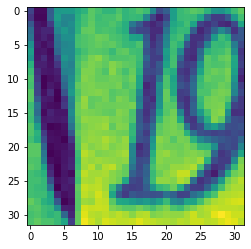

In [0]:
data_train[0][0][0].shape
plt.imshow(data_train[0][0][0])

In [0]:
data_train.data.shape

(73257, 3, 32, 32)

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [0]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler is not None:
            scheduler.step()
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    return float(correct_samples) / total_samples

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

In [0]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

182042624it [00:30, 22756023.20it/s]                               
64282624it [00:25, 20340711.82it/s]                              

Average loss: 2.184056, Train accuracy: 0.198802, Val accuracy: 0.236366
Average loss: 2.006230, Train accuracy: 0.270672, Val accuracy: 0.327964
Average loss: 1.801126, Train accuracy: 0.378920, Val accuracy: 0.401338
Average loss: 1.704909, Train accuracy: 0.420640, Val accuracy: 0.429732
Average loss: 1.677852, Train accuracy: 0.435075, Val accuracy: 0.432530


In [0]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.920230, Train accuracy: 0.379023, Val accuracy: 0.549928
Average loss: 1.476825, Train accuracy: 0.594478, Val accuracy: 0.641458
Average loss: 1.306699, Train accuracy: 0.653704, Val accuracy: 0.673947
Average loss: 1.214027, Train accuracy: 0.681893, Val accuracy: 0.711283
Average loss: 1.156646, Train accuracy: 0.698632, Val accuracy: 0.719883


In [0]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 1.594373, Train accuracy: 0.518769, Val accuracy: 0.551225
Average loss: 1.435015, Train accuracy: 0.607515, Val accuracy: 0.622210
Average loss: 1.392833, Train accuracy: 0.652834, Val accuracy: 0.659887
Average loss: 1.394356, Train accuracy: 0.653653, Val accuracy: 0.613405
Average loss: 1.318091, Train accuracy: 0.698717, Val accuracy: 0.668077
